In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam, AdamW, RAdam
from torch.nn.parameter import Parameter
from torch.nn import NLLLoss, BCEWithLogitsLoss
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torchvision
from torch.nn import Module
import torch.nn.functional as F
from torch.nn import Conv2d, Dropout2d, Linear, Dropout
from torch import cat
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from datetime import datetime
import pprint

d:\miniconda3\Lib\site-packages\pennylane\__init__.py:196: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.0 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
        #torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        ])


train_ds = torchvision.datasets.FashionMNIST(
    "./", train=True, download=True,
    transform=transform)

test_ds = torchvision.datasets.FashionMNIST(
    "./", train=False, download=True,
    transform=transform)


train_mask = (train_ds.targets == 0) | (train_ds.targets == 6)
train_idx = torch.where(train_mask)[0]
train_ds.targets[train_ds.targets == 6] = 1

batch_size = 50

binary_train_ds = Subset(train_ds, train_idx)
train_loader = DataLoader(binary_train_ds, batch_size = batch_size, shuffle =True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [75]:
torch.set_default_dtype(torch.float64)
class BinaryClassifier(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 8, kernel_size=5, padding=2)
        self.conv2 = Conv2d(8, 25, kernel_size=5, padding=2)
        self.dropout = Dropout2d()
        self.fc1 = Linear(25 * 7 * 7, 36)
        self.fn_dropout = Dropout(p=0.1)
        self.fc2 = Linear(36, 4)
        self.fc3 = Linear(4, 1)

        # Quantum layer
        self.num_q_wires = 4
        self.q_device = qml.device("default.qubit", wires=self.num_q_wires)
        
        self.num_q_layers = 1
        qnn_params_size = (self.num_q_layers * 3 + 1) * self.num_q_wires
        qnn_params_tensor = torch.empty(qnn_params_size, requires_grad=True)

        # Kaiming 초기화의 gain 값 계산 (SiLU에 적합한 'leaky_relu'를 사용)
        gain = torch.nn.init.calculate_gain('leaky_relu')
        std = gain / qnn_params_size**0.5 # 텐서 크기를 이용한 표준 편차 계산
        
        # 균등 분포로 파라미터 초기화
        torch.nn.init.uniform_(qnn_params_tensor, -std, std)

        self.qnn_params = Parameter(qnn_params_tensor)

        #@qml.qnode(self.q_device)
        @qml.qnode(self.q_device, interface="torch")
        def circuit(x_batch):
            param_idx = 0 
            for layer in range(self.num_q_layers): # num_q_layers 만큼 반복
                for i in range(self.num_q_wires):
                    qml.H(wires=i)
                    qml.RY(2. * x_batch[:, i], wires=i)
                    
                for i in range(self.num_q_wires):
                    qml.CRY(2. * (torch.pi - x_batch[:, i]) * (torch.pi - x_batch[:, (i+1) % self.num_q_wires]), wires=[i, (i+1)%self.num_q_wires])

                # EfficientSU2
                for i in range(self.num_q_wires):
                    qml.RY(self.qnn_params[param_idx], wires=i)
                    param_idx += 1

                for i in range(self.num_q_wires):
                    qml.CRX(self.qnn_params[param_idx], wires=[i, (i+1)%self.num_q_wires])
                    param_idx += 1
                    #qml.CNOT(wires=[i, (i+1)%self.num_q_wires])

                for i in range(self.num_q_wires):
                    qml.RY(self.qnn_params[param_idx], wires=i)
                    param_idx += 1
                
                for i in range(1, self.num_q_wires):
                    qml.X(wires = i)
                    qml.CRY(2. * (torch.pi - self.qnn_params[param_idx-self.num_q_wires + i-1]) * (torch.pi - self.qnn_params[param_idx-self.num_q_wires + i]), 
                            wires=[i, 0])
                    #param_idx += 1
                    qml.X(wires = i)
                    qml.CNOT(wires=[0, i])
                
                if layer == self.num_q_layers-1:
                    for i in range(self.num_q_wires):
                        qml.RY(self.qnn_params[param_idx], wires=i)
                        param_idx += 1
            
            #return qml.expval(self.obs) # qml.expval은 이제 (BATCH_SIZE,) 형태를 반환
            return [qml.expval(qml.PauliZ(i)) for i in range(self.num_q_wires)]

        self.qnn = circuit

    def forward(self, x):
        #x = F.silu(self.conv1(x))
        x = F.leaky_relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        
        #x = F.silu(self.conv2(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)
        
        #x = F.silu(self.fc1(x))
        x = F.leaky_relu(self.fc1(x))
        #x = F.dropout(x, p=0.1)
        x = self.fn_dropout(x)

        x = self.fc2(x)
        
        #x = self.qnn(x).view(1,)  # apply QNN
        qnn_out = self.qnn(x) 
        x = torch.stack(qnn_out, dim=-1).to(x.device)
        
        x = self.fc3(x)
        return F.log_softmax(cat((x, 1 - x), -1), -1)

bc = BinaryClassifier()
bc.to(device)

BinaryClassifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1225, out_features=36, bias=True)
  (fn_dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=36, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)

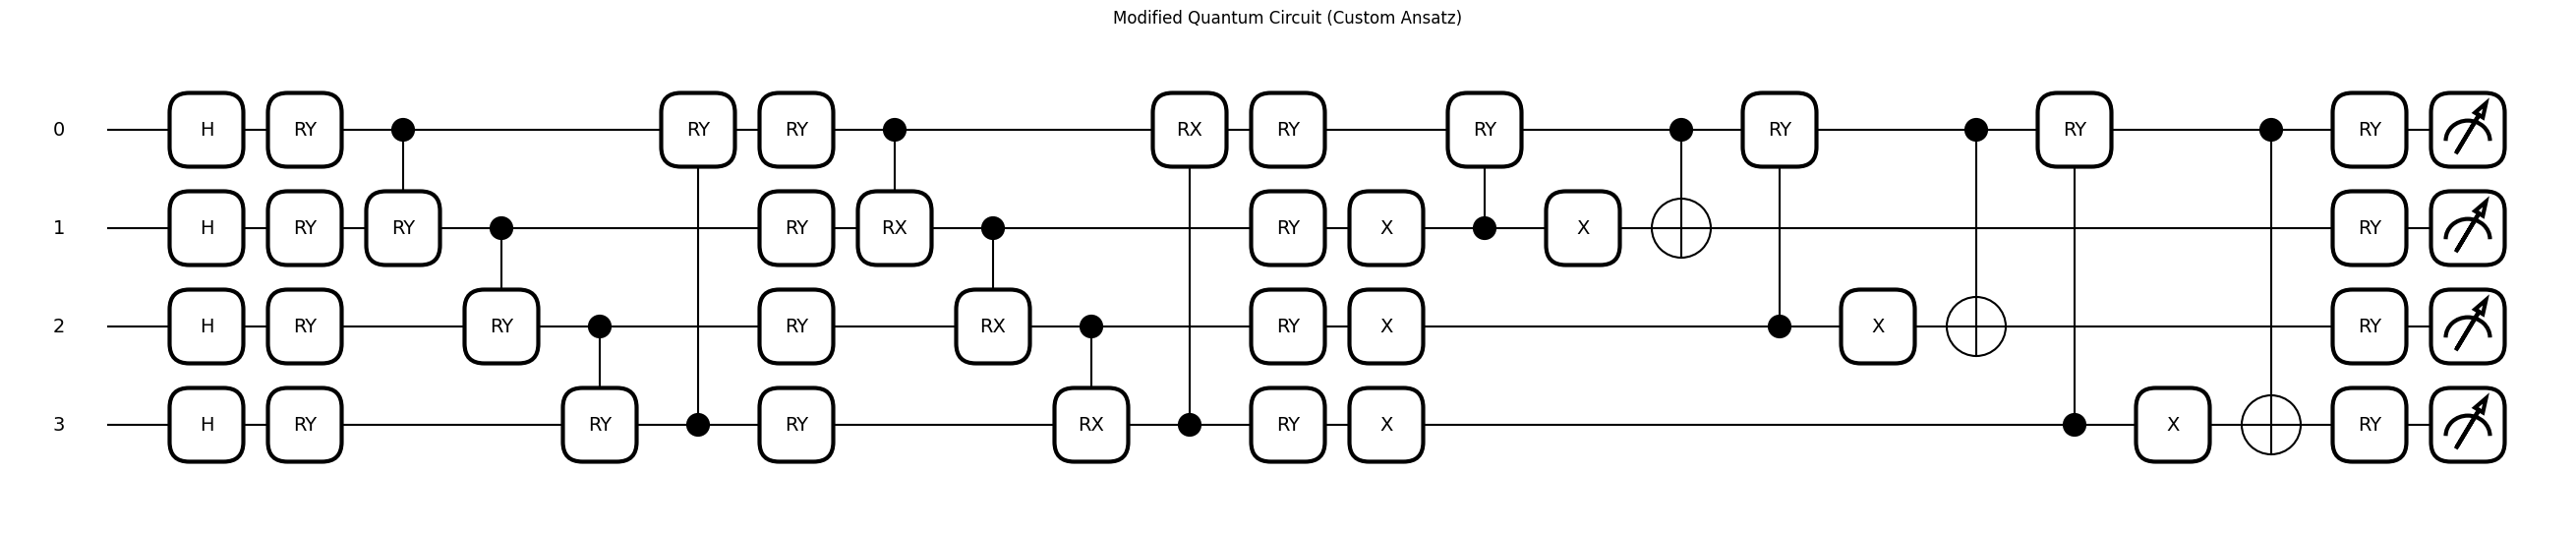

In [76]:
dummy_x = torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], dtype=torch.float64).to(device)
specs = qml.specs(bc.qnn)(dummy_x)
total_params = sum(p.numel() for p in bc.parameters() if p.requires_grad)

# 양자 회로 그리기
fig, ax = qml.draw_mpl(bc.qnn)(dummy_x)
plt.title("Modified Quantum Circuit (Custom Ansatz)")
plt.show()

In [77]:
pprint.pprint(specs, width=1)
print(total_params)
assert specs["num_tape_wires"] <= 8,  "❌ 큐빗 수 초과"
assert specs['resources'].depth <= 30, "❌ 회로 깊이 초과"
assert specs["num_trainable_params"]<= 60, "❌ 학습 퀀텀 파라미터 수 초과"
assert total_params <= 50000, "❌ 학습 전체 파라미터 수 초과"

print("✅ 회로 제약 통과 — 학습을 계속합니다")

{'device_name': 'default.qubit',
 'diff_method': 'best',
 'errors': {},
 'gradient_fn': 'backprop',
 'gradient_options': {},
 'interface': 'torch',
 'level': 'gradient',
 'num_device_wires': 4,
 'num_observables': 4,
 'num_tape_wires': 4,
 'num_trainable_params': 19,
 'resources': Resources(num_wires=4,
                        num_gates=40,
                        gate_types=defaultdict(<class 'int'>,
                                               {'CNOT': 3,
                                                'CRX': 4,
                                                'CRY': 7,
                                                'Hadamard': 4,
                                                'PauliX': 6,
                                                'RY': 16}),
                        gate_sizes=defaultdict(<class 'int'>,
                                               {1: 26,
                                                2: 14}),
                        depth=22,
                        shot

In [78]:
def train_step(epochs=10, lr=0.0010, weight_decay=1e-6):
    optimizer = AdamW(bc.parameters(), lr=lr, weight_decay=weight_decay)
    loss_func  = NLLLoss()

    scheduler = CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader), eta_min=1e-6)

    loss_history = []
    bc.train()


    print(f"Starting training on {device}...")
    for epoch in range(epochs):
        epoch_bar = tqdm(enumerate(train_loader),
                        desc=f"Epoch {epoch+1}/{epochs}",
                        total=len(train_loader),
                        leave=True)

        total_loss = []
        for bidx, (data, target) in epoch_bar:
            data = data.to(device)
            target = target.to(device).flatten().long()
            #target = target.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad(set_to_none=True)

            output = bc(data)
            loss = loss_func(output, target)

            total_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            scheduler.step()

            if bidx % 100 == 0:
                epoch_bar.set_postfix(batch=bidx,
                                    loss=f"{loss.item():.4f}",
                                    lr=f"{optimizer.param_groups[0]['lr']:.6f}")

        avg_loss = sum(total_loss) / len(total_loss)
        loss_history.append(avg_loss)

        print(f"Training [{100.0 * (epoch+1)/epochs:.0f}%] Loss: {avg_loss:.4f}")
        
    return loss_history


In [79]:
def test():
    print(f"Starting inference on {device}...")
    bc.eval()

    all_preds, all_targets = [], []

    with torch.no_grad():
        for data, target in tqdm(test_loader,
                                desc="Inference",
                                total=len(test_loader),
                                leave=False):
            data, target = data.to(device), target.to(device).flatten().long() #target.to(device).float().unsqueeze(1)

            logits = bc(data)

            pred = logits.argmax(dim=-1)
            #probabilities = torch.sigmoid(logits)
            #pred = (probabilities >= 0.5).float().squeeze(1) 

            all_preds.append(pred.cpu())
            all_targets.append(target.cpu())

    y_pred = torch.cat(all_preds).numpy().astype(int)
    y_true = torch.cat(all_targets).numpy().astype(int)

    #y_pred = torch.cat(all_preds).numpy().flatten().astype(int) # .flatten() 추가
    #y_true = torch.cat(all_targets).numpy().flatten().astype(int) # .flatten() 추가

    # --- 8. 평가 및 결과 저장 ---
    # 베이스라인 평가 로직을 따릅니다. y_true는 이제 10000개 길이를 가집니다.
    test_mask = (y_true == 0) | (y_true == 6)

    print("total samples:", len(y_true))
    print("target samples:", test_mask.sum())

    # 모델 결과가 1인 것을 6으로 변경 (제출 형식에 맞게)
    y_pred_mapped = np.where(y_pred == 1, 6, y_pred)

    # 정확도 계산은 0/6 라벨에 대해서만 수행
    acc = (y_pred_mapped[test_mask] == y_true[test_mask]).mean()
    print(f"accuracy (labels 0/6 only): {acc:.4f}")

    now = datetime.now().strftime("%Y%m%d_%H%M%S")

    y_pred_filename = f"y_pred_{now}.csv"

    return y_pred_mapped, y_pred_filename, acc



In [80]:
def plt_loss_history(loss_history, n_repeats, epochs_per_repeat):
    """
    학습 손실 이력을 시각화합니다.
    Args:
        loss_history (list): 에포크별 평균 손실 값 리스트
        n_repeats (int): train_step 함수의 총 반복 횟수 (n)
        epochs_per_repeat (int): 한 번의 train_step에서 에포크 수 (epochs)
    """
    total_epochs = n_repeats * epochs_per_repeat
    x_axis = range(1, total_epochs + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, loss_history)
    plt.title("Training Loss History")
    plt.xlabel("Total Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

# 사용 예시
# loss_history는 모든 반복(n)과 에포크(epochs)의 손실이 담긴 리스트
# loss_history = [ ... ]

# plt_loss_history(loss_history, n_repeats=15, epochs_per_repeat=20)

In [81]:
result = 0
best_result = 0
max_y_pred_filename = ""
best_n = 0
n = 0
epochs = 10
lr = 0.0015
loss_history = []

while result < 0.92:
    lr = 0.0015 * (0.80**n)
    loss_history.extend(train_step(epochs=epochs, lr=lr, weight_decay=batch_size * 1e-6))
    y_pred_mapped, y_pred_filename, result = test()
    print(f"Iteration {n+1}: Result = {result:.4f}")

    if result > best_result:
        best_result = result
        best_n = n
        max_y_pred_filename = y_pred_filename

    n += 1

Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:11<00:00, 20.35it/s, batch=200, loss=0.3619, lr=0.001474]


Training [10%] Loss: 0.4667


Epoch 2/10: 100%|██████████| 240/240 [00:11<00:00, 20.34it/s, batch=200, loss=0.3809, lr=0.001379]


Training [20%] Loss: 0.3528


Epoch 3/10: 100%|██████████| 240/240 [00:11<00:00, 20.24it/s, batch=200, loss=0.3226, lr=0.001221]


Training [30%] Loss: 0.3127


Epoch 4/10: 100%|██████████| 240/240 [00:11<00:00, 21.41it/s, batch=200, loss=0.2904, lr=0.001018]


Training [40%] Loss: 0.2922


Epoch 5/10: 100%|██████████| 240/240 [00:11<00:00, 21.21it/s, batch=200, loss=0.1677, lr=0.000789]


Training [50%] Loss: 0.2733


Epoch 6/10: 100%|██████████| 240/240 [00:11<00:00, 20.56it/s, batch=200, loss=0.3509, lr=0.000556]


Training [60%] Loss: 0.2566


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.45it/s, batch=200, loss=0.2594, lr=0.000341]


Training [70%] Loss: 0.2401


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.47it/s, batch=200, loss=0.1177, lr=0.000167]


Training [80%] Loss: 0.2307


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.61it/s, batch=200, loss=0.1487, lr=0.000050]


Training [90%] Loss: 0.2271


Epoch 10/10: 100%|██████████| 240/240 [00:11<00:00, 20.17it/s, batch=200, loss=0.2463, lr=0.000002]


Training [100%] Loss: 0.2205
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8815
Iteration 1: Result = 0.8815
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.39it/s, batch=200, loss=0.1773, lr=0.001179]


Training [10%] Loss: 0.2494


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.84it/s, batch=200, loss=0.1565, lr=0.001103]


Training [20%] Loss: 0.2428


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.54it/s, batch=200, loss=0.2470, lr=0.000977]


Training [30%] Loss: 0.2354


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.37it/s, batch=200, loss=0.2604, lr=0.000815]


Training [40%] Loss: 0.2256


Epoch 5/10: 100%|██████████| 240/240 [00:11<00:00, 20.26it/s, batch=200, loss=0.2087, lr=0.000631]


Training [50%] Loss: 0.2167


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.88it/s, batch=200, loss=0.3395, lr=0.000445]


Training [60%] Loss: 0.1993


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.38it/s, batch=200, loss=0.2287, lr=0.000273]


Training [70%] Loss: 0.1952


Epoch 8/10: 100%|██████████| 240/240 [00:17<00:00, 13.83it/s, batch=200, loss=0.1932, lr=0.000134]


Training [80%] Loss: 0.1813


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 21.63it/s, batch=200, loss=0.1870, lr=0.000041]


Training [90%] Loss: 0.1811


Epoch 10/10: 100%|██████████| 240/240 [00:11<00:00, 21.69it/s, batch=200, loss=0.2167, lr=0.000002]


Training [100%] Loss: 0.1744
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8835
Iteration 2: Result = 0.8835
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:11<00:00, 20.50it/s, batch=200, loss=0.1113, lr=0.000943]


Training [10%] Loss: 0.2052


Epoch 2/10: 100%|██████████| 240/240 [00:11<00:00, 20.05it/s, batch=200, loss=0.1639, lr=0.000882]


Training [20%] Loss: 0.1985


Epoch 3/10: 100%|██████████| 240/240 [00:11<00:00, 20.52it/s, batch=200, loss=0.2452, lr=0.000782]


Training [30%] Loss: 0.1943


Epoch 4/10: 100%|██████████| 240/240 [00:11<00:00, 20.46it/s, batch=200, loss=0.2364, lr=0.000652]


Training [40%] Loss: 0.1897


Epoch 5/10: 100%|██████████| 240/240 [00:11<00:00, 20.55it/s, batch=200, loss=0.0861, lr=0.000505]


Training [50%] Loss: 0.1792


Epoch 6/10: 100%|██████████| 240/240 [00:11<00:00, 20.37it/s, batch=200, loss=0.1857, lr=0.000356]


Training [60%] Loss: 0.1687


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.44it/s, batch=200, loss=0.1986, lr=0.000219]


Training [70%] Loss: 0.1608


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.25it/s, batch=200, loss=0.1964, lr=0.000107]


Training [80%] Loss: 0.1477


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.12it/s, batch=200, loss=0.0942, lr=0.000033]


Training [90%] Loss: 0.1469


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.46it/s, batch=200, loss=0.0690, lr=0.000002]


Training [100%] Loss: 0.1464
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8880
Iteration 3: Result = 0.8880
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.91it/s, batch=200, loss=0.2100, lr=0.000755]


Training [10%] Loss: 0.1682


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.42it/s, batch=200, loss=0.1298, lr=0.000706]


Training [20%] Loss: 0.1706


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.62it/s, batch=200, loss=0.0948, lr=0.000625]


Training [30%] Loss: 0.1629


Epoch 4/10: 100%|██████████| 240/240 [00:11<00:00, 20.13it/s, batch=200, loss=0.2004, lr=0.000521]


Training [40%] Loss: 0.1555


Epoch 5/10: 100%|██████████| 240/240 [00:11<00:00, 20.30it/s, batch=200, loss=0.1145, lr=0.000404]


Training [50%] Loss: 0.1519


Epoch 6/10: 100%|██████████| 240/240 [00:11<00:00, 20.44it/s, batch=200, loss=0.3129, lr=0.000285]


Training [60%] Loss: 0.1450


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.44it/s, batch=200, loss=0.1071, lr=0.000175]


Training [70%] Loss: 0.1346


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.49it/s, batch=200, loss=0.1196, lr=0.000086]


Training [80%] Loss: 0.1321


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.67it/s, batch=200, loss=0.0720, lr=0.000026]


Training [90%] Loss: 0.1259


Epoch 10/10: 100%|██████████| 240/240 [00:13<00:00, 18.07it/s, batch=200, loss=0.1329, lr=0.000001]


Training [100%] Loss: 0.1240
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8905
Iteration 4: Result = 0.8905
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:16<00:00, 14.79it/s, batch=200, loss=0.0621, lr=0.000604]


Training [10%] Loss: 0.1487


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.90it/s, batch=200, loss=0.1342, lr=0.000565]


Training [20%] Loss: 0.1404


Epoch 3/10: 100%|██████████| 240/240 [13:05<00:00,  3.27s/it, batch=200, loss=0.1332, lr=0.000500]  


Training [30%] Loss: 0.1376


Epoch 4/10: 100%|██████████| 240/240 [00:11<00:00, 20.15it/s, batch=200, loss=0.0827, lr=0.000417]


Training [40%] Loss: 0.1309


Epoch 5/10: 100%|██████████| 240/240 [00:10<00:00, 22.30it/s, batch=200, loss=0.1230, lr=0.000323]


Training [50%] Loss: 0.1265


Epoch 6/10: 100%|██████████| 240/240 [00:10<00:00, 22.59it/s, batch=200, loss=0.0366, lr=0.000228]


Training [60%] Loss: 0.1208


Epoch 7/10: 100%|██████████| 240/240 [00:10<00:00, 22.28it/s, batch=200, loss=0.1109, lr=0.000140]


Training [70%] Loss: 0.1112


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.76it/s, batch=200, loss=0.1788, lr=0.000069]


Training [80%] Loss: 0.1103


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.82it/s, batch=200, loss=0.0889, lr=0.000021]


Training [90%] Loss: 0.1062


Epoch 10/10: 100%|██████████| 240/240 [00:11<00:00, 20.27it/s, batch=200, loss=0.0895, lr=0.000001]


Training [100%] Loss: 0.1064
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8895
Iteration 5: Result = 0.8895
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:16<00:00, 14.38it/s, batch=200, loss=0.2022, lr=0.000483]


Training [10%] Loss: 0.1241


Epoch 2/10: 100%|██████████| 240/240 [00:10<00:00, 21.98it/s, batch=200, loss=0.0999, lr=0.000452]


Training [20%] Loss: 0.1261


Epoch 3/10: 100%|██████████| 240/240 [00:16<00:00, 14.57it/s, batch=200, loss=0.1766, lr=0.000400]


Training [30%] Loss: 0.1203


Epoch 4/10: 100%|██████████| 240/240 [00:11<00:00, 21.47it/s, batch=200, loss=0.1139, lr=0.000334]


Training [40%] Loss: 0.1211


Epoch 5/10: 100%|██████████| 240/240 [00:11<00:00, 21.28it/s, batch=200, loss=0.0592, lr=0.000259]


Training [50%] Loss: 0.1077


Epoch 6/10: 100%|██████████| 240/240 [00:11<00:00, 20.45it/s, batch=200, loss=0.1924, lr=0.000182]


Training [60%] Loss: 0.1076


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.91it/s, batch=200, loss=0.1520, lr=0.000112]


Training [70%] Loss: 0.1015


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.50it/s, batch=200, loss=0.0508, lr=0.000055]


Training [80%] Loss: 0.1037


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.58it/s, batch=200, loss=0.2500, lr=0.000017]


Training [90%] Loss: 0.0959


Epoch 10/10: 100%|██████████| 240/240 [00:11<00:00, 20.87it/s, batch=200, loss=0.1463, lr=0.000001]


Training [100%] Loss: 0.0942
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8860
Iteration 6: Result = 0.8860
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:11<00:00, 20.54it/s, batch=200, loss=0.1217, lr=0.000386]


Training [10%] Loss: 0.1106


Epoch 2/10: 100%|██████████| 240/240 [00:11<00:00, 20.99it/s, batch=200, loss=0.0544, lr=0.000361]


Training [20%] Loss: 0.1058


Epoch 3/10: 100%|██████████| 240/240 [00:11<00:00, 21.03it/s, batch=200, loss=0.1094, lr=0.000320]


Training [30%] Loss: 0.1050


Epoch 4/10: 100%|██████████| 240/240 [00:11<00:00, 20.69it/s, batch=200, loss=0.0266, lr=0.000267]


Training [40%] Loss: 0.1005


Epoch 5/10: 100%|██████████| 240/240 [00:11<00:00, 21.43it/s, batch=200, loss=0.0995, lr=0.000207]


Training [50%] Loss: 0.1008


Epoch 6/10: 100%|██████████| 240/240 [00:10<00:00, 22.16it/s, batch=200, loss=0.1700, lr=0.000146]


Training [60%] Loss: 0.0977


Epoch 7/10: 100%|██████████| 240/240 [00:10<00:00, 22.05it/s, batch=200, loss=0.0519, lr=0.000090]


Training [70%] Loss: 0.0895


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.90it/s, batch=200, loss=0.0336, lr=0.000045]


Training [80%] Loss: 0.0904


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.77it/s, batch=200, loss=0.0492, lr=0.000014]


Training [90%] Loss: 0.0868


Epoch 10/10: 100%|██████████| 240/240 [00:11<00:00, 20.16it/s, batch=200, loss=0.0276, lr=0.000001]


Training [100%] Loss: 0.0877
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8875
Iteration 7: Result = 0.8875
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:11<00:00, 21.08it/s, batch=200, loss=0.1390, lr=0.000309]


Training [10%] Loss: 0.0941


Epoch 2/10: 100%|██████████| 240/240 [00:11<00:00, 20.89it/s, batch=200, loss=0.0508, lr=0.000289]


Training [20%] Loss: 0.1003


Epoch 3/10: 100%|██████████| 240/240 [00:11<00:00, 20.85it/s, batch=200, loss=0.0774, lr=0.000256]


Training [30%] Loss: 0.0937


Epoch 4/10: 100%|██████████| 240/240 [00:11<00:00, 21.14it/s, batch=200, loss=0.1238, lr=0.000214]


Training [40%] Loss: 0.0950


Epoch 5/10: 100%|██████████| 240/240 [00:11<00:00, 20.99it/s, batch=200, loss=0.0711, lr=0.000166]


Training [50%] Loss: 0.0895


Epoch 6/10: 100%|██████████| 240/240 [00:11<00:00, 21.72it/s, batch=200, loss=0.0636, lr=0.000117]


Training [60%] Loss: 0.0885


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 21.11it/s, batch=200, loss=0.0257, lr=0.000072]


Training [70%] Loss: 0.0819


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.86it/s, batch=200, loss=0.1367, lr=0.000036]


Training [80%] Loss: 0.0847


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.88it/s, batch=200, loss=0.0766, lr=0.000011]


Training [90%] Loss: 0.0810


Epoch 10/10: 100%|██████████| 240/240 [00:11<00:00, 20.39it/s, batch=200, loss=0.0980, lr=0.000001]


Training [100%] Loss: 0.0789
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8855
Iteration 8: Result = 0.8855
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:11<00:00, 20.91it/s, batch=200, loss=0.0833, lr=0.000247]


Training [10%] Loss: 0.0893


Epoch 2/10: 100%|██████████| 240/240 [00:11<00:00, 20.09it/s, batch=200, loss=0.1925, lr=0.000231]


Training [20%] Loss: 0.0897


Epoch 3/10: 100%|██████████| 240/240 [00:16<00:00, 14.48it/s, batch=200, loss=0.1393, lr=0.000205]


Training [30%] Loss: 0.0866


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 18.79it/s, batch=200, loss=0.2001, lr=0.000171]


Training [40%] Loss: 0.0875


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.41it/s, batch=200, loss=0.0438, lr=0.000133]


Training [50%] Loss: 0.0793


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.97it/s, batch=200, loss=0.0420, lr=0.000094]


Training [60%] Loss: 0.0787


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.47it/s, batch=200, loss=0.0621, lr=0.000058]


Training [70%] Loss: 0.0773


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.86it/s, batch=200, loss=0.0374, lr=0.000029]


Training [80%] Loss: 0.0811


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.99it/s, batch=200, loss=0.1415, lr=0.000009]


Training [90%] Loss: 0.0757


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.89it/s, batch=200, loss=0.1236, lr=0.000001]


Training [100%] Loss: 0.0772
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8890
Iteration 9: Result = 0.8890
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.52it/s, batch=200, loss=0.0472, lr=0.000198]


Training [10%] Loss: 0.0778


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.89it/s, batch=200, loss=0.0581, lr=0.000185]


Training [20%] Loss: 0.0824


Epoch 3/10: 100%|██████████| 240/240 [00:11<00:00, 20.08it/s, batch=200, loss=0.0151, lr=0.000164]


Training [30%] Loss: 0.0844


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.91it/s, batch=200, loss=0.0866, lr=0.000137]


Training [40%] Loss: 0.0739


Epoch 5/10: 100%|██████████| 240/240 [00:15<00:00, 15.62it/s, batch=200, loss=0.0173, lr=0.000106]


Training [50%] Loss: 0.0747


Epoch 6/10: 100%|██████████| 240/240 [00:15<00:00, 15.44it/s, batch=200, loss=0.0650, lr=0.000075]


Training [60%] Loss: 0.0728


Epoch 7/10: 100%|██████████| 240/240 [00:23<00:00, 10.03it/s, batch=200, loss=0.0871, lr=0.000047]


Training [70%] Loss: 0.0718


Epoch 8/10: 100%|██████████| 240/240 [00:13<00:00, 17.19it/s, batch=200, loss=0.0262, lr=0.000023]


Training [80%] Loss: 0.0685


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.03it/s, batch=200, loss=0.0485, lr=0.000008]


Training [90%] Loss: 0.0673


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 18.93it/s, batch=200, loss=0.0217, lr=0.000001]


Training [100%] Loss: 0.0709
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8860
Iteration 10: Result = 0.8860
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.11it/s, batch=200, loss=0.0997, lr=0.000158]


Training [10%] Loss: 0.0792


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.22it/s, batch=200, loss=0.0778, lr=0.000148]


Training [20%] Loss: 0.0750


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 18.86it/s, batch=200, loss=0.0636, lr=0.000131]


Training [30%] Loss: 0.0675


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.57it/s, batch=200, loss=0.0601, lr=0.000110]


Training [40%] Loss: 0.0789


Epoch 5/10: 100%|██████████| 240/240 [00:11<00:00, 20.01it/s, batch=200, loss=0.0573, lr=0.000085]


Training [50%] Loss: 0.0667


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.89it/s, batch=200, loss=0.0215, lr=0.000060]


Training [60%] Loss: 0.0668


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.40it/s, batch=200, loss=0.0725, lr=0.000037]


Training [70%] Loss: 0.0661


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.01it/s, batch=200, loss=0.0492, lr=0.000019]


Training [80%] Loss: 0.0652


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 18.59it/s, batch=200, loss=0.0512, lr=0.000006]


Training [90%] Loss: 0.0668


Epoch 10/10: 100%|██████████| 240/240 [00:13<00:00, 17.84it/s, batch=200, loss=0.0055, lr=0.000001]


Training [100%] Loss: 0.0666
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8870
Iteration 11: Result = 0.8870
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:15<00:00, 15.46it/s, batch=200, loss=0.0245, lr=0.000127]


Training [10%] Loss: 0.0677


Epoch 2/10: 100%|██████████| 240/240 [00:15<00:00, 15.51it/s, batch=200, loss=0.1601, lr=0.000118]


Training [20%] Loss: 0.0690


Epoch 3/10: 100%|██████████| 240/240 [00:18<00:00, 13.04it/s, batch=200, loss=0.0578, lr=0.000105]


Training [30%] Loss: 0.0665


Epoch 4/10: 100%|██████████| 240/240 [00:17<00:00, 13.40it/s, batch=200, loss=0.0993, lr=0.000088]


Training [40%] Loss: 0.0740


Epoch 5/10: 100%|██████████| 240/240 [00:18<00:00, 13.30it/s, batch=200, loss=0.0822, lr=0.000068]


Training [50%] Loss: 0.0705


Epoch 6/10: 100%|██████████| 240/240 [00:13<00:00, 17.16it/s, batch=200, loss=0.1537, lr=0.000048]


Training [60%] Loss: 0.0644


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.50it/s, batch=200, loss=0.0081, lr=0.000030]


Training [70%] Loss: 0.0658


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.94it/s, batch=200, loss=0.0669, lr=0.000015]


Training [80%] Loss: 0.0642


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.27it/s, batch=200, loss=0.0423, lr=0.000005]


Training [90%] Loss: 0.0690


Epoch 10/10: 100%|██████████| 240/240 [00:15<00:00, 15.10it/s, batch=200, loss=0.0278, lr=0.000001]


Training [100%] Loss: 0.0662
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8865
Iteration 12: Result = 0.8865
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.30it/s, batch=200, loss=0.1242, lr=0.000101]


Training [10%] Loss: 0.0713


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.49it/s, batch=200, loss=0.0307, lr=0.000095]


Training [20%] Loss: 0.0647


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.50it/s, batch=200, loss=0.0684, lr=0.000084]


Training [30%] Loss: 0.0652


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.41it/s, batch=200, loss=0.0851, lr=0.000070]


Training [40%] Loss: 0.0683


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.96it/s, batch=200, loss=0.1327, lr=0.000055]


Training [50%] Loss: 0.0669


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.31it/s, batch=200, loss=0.1020, lr=0.000039]


Training [60%] Loss: 0.0649


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.01it/s, batch=200, loss=0.0192, lr=0.000024]


Training [70%] Loss: 0.0631


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.91it/s, batch=200, loss=0.1331, lr=0.000012]


Training [80%] Loss: 0.0610


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.13it/s, batch=200, loss=0.0678, lr=0.000004]


Training [90%] Loss: 0.0628


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.23it/s, batch=200, loss=0.0305, lr=0.000001]


Training [100%] Loss: 0.0672
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8885
Iteration 13: Result = 0.8885
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:13<00:00, 17.47it/s, batch=200, loss=0.0635, lr=0.000081]


Training [10%] Loss: 0.0667


Epoch 2/10: 100%|██████████| 240/240 [00:17<00:00, 13.48it/s, batch=200, loss=0.0102, lr=0.000076]


Training [20%] Loss: 0.0613


Epoch 3/10: 100%|██████████| 240/240 [00:18<00:00, 13.25it/s, batch=200, loss=0.0756, lr=0.000067]


Training [30%] Loss: 0.0650


Epoch 4/10: 100%|██████████| 240/240 [00:14<00:00, 16.55it/s, batch=200, loss=0.0501, lr=0.000056]


Training [40%] Loss: 0.0687


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.36it/s, batch=200, loss=0.0134, lr=0.000044]


Training [50%] Loss: 0.0661


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.49it/s, batch=200, loss=0.0661, lr=0.000031]


Training [60%] Loss: 0.0672


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.72it/s, batch=200, loss=0.0127, lr=0.000020]


Training [70%] Loss: 0.0652


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.72it/s, batch=200, loss=0.0806, lr=0.000010]


Training [80%] Loss: 0.0656


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.20it/s, batch=200, loss=0.1497, lr=0.000004]


Training [90%] Loss: 0.0597


Epoch 10/10: 100%|██████████| 240/240 [00:15<00:00, 15.24it/s, batch=200, loss=0.0452, lr=0.000001]


Training [100%] Loss: 0.0596
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8915
Iteration 14: Result = 0.8915
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:13<00:00, 17.52it/s, batch=200, loss=0.0613, lr=0.000065]


Training [10%] Loss: 0.0627


Epoch 2/10: 100%|██████████| 240/240 [00:11<00:00, 20.45it/s, batch=200, loss=0.0923, lr=0.000061]


Training [20%] Loss: 0.0610


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.95it/s, batch=200, loss=0.0079, lr=0.000054]


Training [30%] Loss: 0.0607


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.60it/s, batch=200, loss=0.0704, lr=0.000045]


Training [40%] Loss: 0.0616


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.54it/s, batch=200, loss=0.1197, lr=0.000035]


Training [50%] Loss: 0.0625


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.55it/s, batch=200, loss=0.0446, lr=0.000025]


Training [60%] Loss: 0.0612


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.24it/s, batch=200, loss=0.0433, lr=0.000016]


Training [70%] Loss: 0.0604


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.99it/s, batch=200, loss=0.0106, lr=0.000008]


Training [80%] Loss: 0.0585


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.43it/s, batch=200, loss=0.0200, lr=0.000003]


Training [90%] Loss: 0.0580


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.06it/s, batch=200, loss=0.1464, lr=0.000001]


Training [100%] Loss: 0.0610
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8900
Iteration 15: Result = 0.8900
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:13<00:00, 17.60it/s, batch=200, loss=0.0604, lr=0.000052]


Training [10%] Loss: 0.0621


Epoch 2/10: 100%|██████████| 240/240 [00:17<00:00, 13.50it/s, batch=200, loss=0.0153, lr=0.000049]


Training [20%] Loss: 0.0604


Epoch 3/10: 100%|██████████| 240/240 [00:17<00:00, 13.63it/s, batch=200, loss=0.1143, lr=0.000043]


Training [30%] Loss: 0.0616


Epoch 4/10: 100%|██████████| 240/240 [00:17<00:00, 13.86it/s, batch=200, loss=0.0167, lr=0.000036]


Training [40%] Loss: 0.0610


Epoch 5/10: 100%|██████████| 240/240 [00:13<00:00, 17.88it/s, batch=200, loss=0.1128, lr=0.000028]


Training [50%] Loss: 0.0605


Epoch 6/10: 100%|██████████| 240/240 [00:11<00:00, 20.07it/s, batch=200, loss=0.1853, lr=0.000020]


Training [60%] Loss: 0.0585


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.20it/s, batch=200, loss=0.0527, lr=0.000013]


Training [70%] Loss: 0.0635


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.69it/s, batch=200, loss=0.0987, lr=0.000007]


Training [80%] Loss: 0.0607


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.99it/s, batch=200, loss=0.0387, lr=0.000003]


Training [90%] Loss: 0.0566


Epoch 10/10: 100%|██████████| 240/240 [00:11<00:00, 21.09it/s, batch=200, loss=0.0578, lr=0.000001]


Training [100%] Loss: 0.0602
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8885
Iteration 16: Result = 0.8885
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:11<00:00, 20.67it/s, batch=200, loss=0.1459, lr=0.000042]


Training [10%] Loss: 0.0597


Epoch 2/10: 100%|██████████| 240/240 [00:11<00:00, 20.20it/s, batch=200, loss=0.0509, lr=0.000039]


Training [20%] Loss: 0.0593


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 18.84it/s, batch=200, loss=0.0224, lr=0.000035]


Training [30%] Loss: 0.0570


Epoch 4/10: 100%|██████████| 240/240 [00:18<00:00, 13.32it/s, batch=200, loss=0.0059, lr=0.000029]


Training [40%] Loss: 0.0611


Epoch 5/10: 100%|██████████| 240/240 [00:17<00:00, 13.42it/s, batch=200, loss=0.0832, lr=0.000023]


Training [50%] Loss: 0.0563


Epoch 6/10: 100%|██████████| 240/240 [00:20<00:00, 11.63it/s, batch=200, loss=0.0725, lr=0.000016]


Training [60%] Loss: 0.0599


Epoch 7/10: 100%|██████████| 240/240 [00:19<00:00, 12.62it/s, batch=200, loss=0.0749, lr=0.000010]


Training [70%] Loss: 0.0571


Epoch 8/10: 100%|██████████| 240/240 [00:17<00:00, 13.44it/s, batch=200, loss=0.0140, lr=0.000006]


Training [80%] Loss: 0.0606


Epoch 9/10: 100%|██████████| 240/240 [00:18<00:00, 13.20it/s, batch=200, loss=0.0365, lr=0.000002]


Training [90%] Loss: 0.0606


Epoch 10/10: 100%|██████████| 240/240 [00:17<00:00, 13.51it/s, batch=200, loss=0.0580, lr=0.000001]


Training [100%] Loss: 0.0556
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8880
Iteration 17: Result = 0.8880
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:17<00:00, 13.45it/s, batch=200, loss=0.1113, lr=0.000033]


Training [10%] Loss: 0.0600


Epoch 2/10: 100%|██████████| 240/240 [00:17<00:00, 14.05it/s, batch=200, loss=0.0248, lr=0.000031]


Training [20%] Loss: 0.0600


Epoch 3/10: 100%|██████████| 240/240 [00:17<00:00, 13.72it/s, batch=200, loss=0.0497, lr=0.000028]


Training [30%] Loss: 0.0601


Epoch 4/10: 100%|██████████| 240/240 [00:16<00:00, 14.19it/s, batch=200, loss=0.0487, lr=0.000023]


Training [40%] Loss: 0.0610


Epoch 5/10: 100%|██████████| 240/240 [00:16<00:00, 14.53it/s, batch=200, loss=0.0058, lr=0.000018]


Training [50%] Loss: 0.0594


Epoch 6/10: 100%|██████████| 240/240 [00:11<00:00, 21.07it/s, batch=200, loss=0.0885, lr=0.000013]


Training [60%] Loss: 0.0581


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.97it/s, batch=200, loss=0.0922, lr=0.000008]


Training [70%] Loss: 0.0586


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 21.08it/s, batch=200, loss=0.0374, lr=0.000005]


Training [80%] Loss: 0.0590


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 21.21it/s, batch=200, loss=0.0489, lr=0.000002]


Training [90%] Loss: 0.0567


Epoch 10/10: 100%|██████████| 240/240 [00:11<00:00, 21.29it/s, batch=200, loss=0.0208, lr=0.000001]


Training [100%] Loss: 0.0596
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8865
Iteration 18: Result = 0.8865
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:11<00:00, 20.47it/s, batch=200, loss=0.1092, lr=0.000027]


Training [10%] Loss: 0.0563


Epoch 2/10:  44%|████▍     | 106/240 [00:05<00:06, 19.47it/s, batch=100, loss=0.0964, lr=0.000026]


KeyboardInterrupt: 

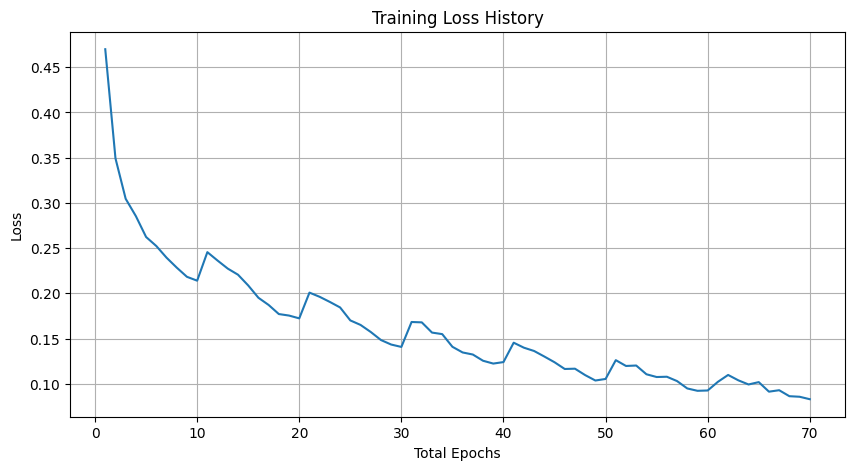

Best result: 0.8950 at iteration 6
Prediction saved to y_pred_20250811_174837.csv


In [16]:
plt_loss_history(loss_history, n, epochs)
print(f"Best result: {best_result:.4f} at iteration {best_n}")
# 전체 10000개 샘플에 대한 예측을 저장 (대회 제출 형식)
np.savetxt(y_pred_filename, y_pred_mapped, fmt="%d")
print(f"Prediction saved to {max_y_pred_filename}")